King County Real Estate '14-'15 Analysis 

Authors: Andrew Marinelli, Drew Bernklau, and Andy Schmeck ("The Andrew's Three)

# Overview

<img src="Images/King_County_homes_map.png" width=600 height=200 />

This project analyzes data for Real Estate Company, dealing with hundreds of clients all over the Puget Sound area.  Descriptive analysis of the housing data, from King County, Washington between May 2014 to May 2015, show that homes vary in sale price due to many factors. Real Estate Company can use this anaysis to modify client interactions and offer more targeted advice in listing and selling their home. 

# Business Problem

One of the most frequently asked questions of realtors is "How should I prepare my house before selling it?" (RentSpree). Real Estate Company may be able to improve client relations and increase profits with a few targeted recommendations provided to the homeowners about which home renovations and improvements might increase the estimated value of their homes, increasing income for homeowner and realator.

<img src="Images/puget sound.jpg" width=500 height=200 />

# Data

The dataset is of King County 21,597 home sales between May 2014 through May 2015. Every home has a unique id; 92 homes were sold twice within the year. With price as the target variable, features that influenced a homeowner's selling price were kept: id, bedrooms, bathrooms, condition, price. 

In [1]:
import pandas as pd
import code.project2_cleaning as cln
import code.project2_viz as viz
import matplotlib.pyplot as plt

data = pd.read_csv('data/kc_house_data.csv')

#### Train-Test-Split

The data was split 75%/25% 

In [2]:
X_train, X_test, y_train, y_test = cln.splitting(data)

#### Excluding

Some features were excluded due to multicollinearity sqft_living, sqft_living15, sqft_above, and sqft_basement. We chose to keep bathrooms as the most specific of the group. 

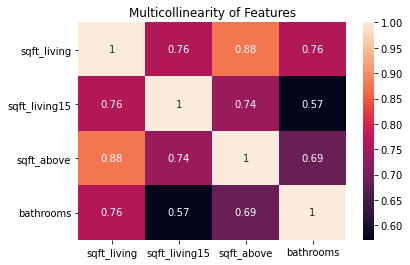

In [3]:
viz.correlations(X_train)


Many features were excluded because of our business problem. If the homeowner was not able to make the changes to their own house, the features were excluded. This included floors, yr_built, grade, view, waterfront, date, zipcode, yr_renovated, lat, long, sqft_lot, sqft_living15, and sqft_lot15. As an example, the advice, "move your house to the waterfront," would not be helpful to a homeowner who does not live on the waterfront. 

In [4]:
X_train = cln.dropped(X_train)

Features dropped:
['bathrooms', 'floors', 'yr_built', 'grade', 'view', 'waterfront', 'date', 'zipcode', 'yr_renovated', 'lat', 'long', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']


# Methods

Some outliers in price, greater than 3 standard deviations from the mean, were removed.

In [5]:
X_train, y_train = cln.rem_outliers(X_train, y_train)

Houses with square feet of living greater than 4838.32 removed.


#### One Hot Encoder "Condition"

To change the condition of the home into discrete variables, OneHotEncoder was applied to the training data.

In [6]:
o_h_e, X_train = cln.ohe_train(X_train)

Categories encoded and added as columns:
['Average' 'Fair' 'Good' 'Poor' 'Very Good']


#### Stepwise Selection Function

To precisely determine features to use within our model, a stepwise selection function was finally applied to the cleaned data. 

In [7]:
X_train = X_train[cln.stepwise_selection(X_train, y_train)]

resulting features:
['sqft_living', 'bedrooms', 'VeryGood', 'Good', 'id', 'id']


#### Test set cleaning

Do the same above to the test set before modeling

In [8]:
#drop columns
X_test = cln.dropped(X_test)
print('\n')

#remove outliers
X_test, y_test = cln.rem_outliers(X_test, y_test)
print('\n')

#OHE Condition
X_test = cln.ohe_test(o_h_e, X_test)
print('\n')
#Stepwise Selection

X_test = X_test[cln.stepwise_selection(X_test, y_test)]

Features dropped:
['bathrooms', 'floors', 'yr_built', 'grade', 'view', 'waterfront', 'date', 'zipcode', 'yr_renovated', 'lat', 'long', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']


Houses with square feet of living greater than 4823.63 removed.


Categories encoded and added as columns:
['Average' 'Fair' 'Good' 'Poor' 'Very Good']


resulting features:
['sqft_living', 'bedrooms', 'VeryGood', 'Good', 'id']


# Modeling

#### Baseline

In [9]:
#Baseline Dummy Regressor
train_score, y_train_hat, test_score, y_test_hat = cln.dummy_modeling(X_train, X_test, y_train, y_test)

R^2 of train set:
0.0


In [10]:
#Baseline R^2 Validation
print('R^2 of train set:')
print(test_score)

R^2 of train set:
-0.00016199324258603376


In [11]:
#Baseline RMSE
baseline_rmse = cln.calc_rmse(y_train, y_train_hat)

Root Mean Squared Error:
[313947.14167348493]


In [12]:
#Baseline Test RMSE
baseline_test_rmse = cln.calc_rmse(y_test, y_test_hat)

Root Mean Squared Error:
[306355.96373586426]


#### Simple Linear Regression

In [13]:
#OLS with price and bathrooms
y_train_hat, y_test_hat, residuals = cln.regression_single(X_train, X_test, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 1.206e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:55:37   Log-Likelihood:            -2.2079e+05
No. Observations:               16005   AIC:                         4.416e+05
Df Residuals:                   16003   BIC:                         4.416e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.264e+04   5023.962      2.516      

In [14]:
#1st Model RMSE
single_rmse = cln.calc_rmse(y_train, y_train_hat)

Root Mean Squared Error:
[237092.22939347464]


In [15]:
#1st RMSE Validation
single_test_rmse = cln.calc_rmse(y_test, y_test_hat)

Root Mean Squared Error:
[230766.11775401162]


C:\Users\andre\Documents\Flatirons\phase_2_project\project_contents\Phase_2_Project----DrewB-AndrewM-AndyS\code\project2_cleaning.py:188: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


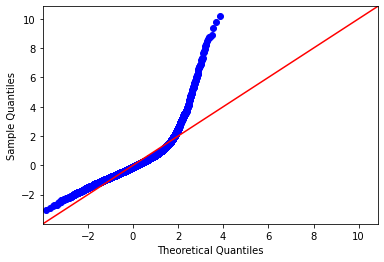

In [16]:
#Check Normality of Residuals
cln.resid_map(residuals)

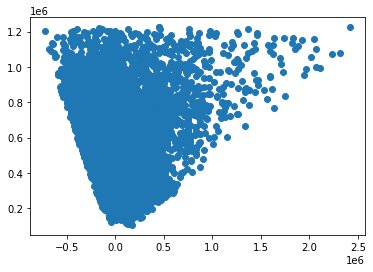

In [17]:
#Check Homoscedasticity of Residuals
plt.scatter(residuals, y_train_hat)

#### Mulitiple Linear Regression

In [20]:
#Stepwise Function

In [19]:
#Multiple OLS with Stepwise Results
y_train_hat, y_test_hat, residuals = cln.regression_multiple(X_train, X_test, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     3322.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:55:41   Log-Likelihood:            -2.2045e+05
No. Observations:               16005   AIC:                         4.409e+05
Df Residuals:                   16000   BIC:                         4.409e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.741e+04   7277.531     13.385      

In [22]:
#Multiple OLS RMSE
multiple_rmse = cln.calc_rmse(y_train, y_train_hat)

Root Mean Squared Error:
[232040.97638003607]


In [23]:
#Multiple OLS RMSE
multiple_test_rmse = cln.calc_rmse(y_test, y_test_hat)

Root Mean Squared Error:
[227552.39461939357]


C:\Users\andre\Documents\Flatirons\phase_2_project\project_contents\Phase_2_Project----DrewB-AndrewM-AndyS\code\project2_cleaning.py:188: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


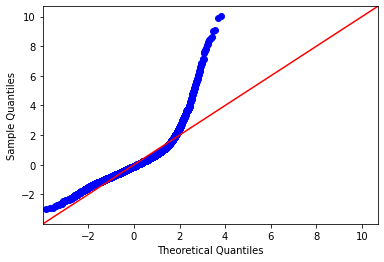

In [24]:
#Check Normality of Residuals
cln.resid_map(residuals)

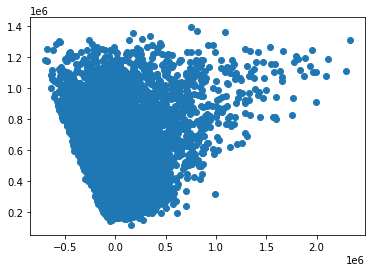

In [25]:
#Check Homoscedasticity of Residuals
plt.scatter(residuals, y_train_hat);

# Conclusion

regression perfromance
interpretation
recommendations

# Next Steps